ESPCN 
Efficient Sub-Pixel Convolutional Neural
高效亚像素卷积神经网络

In [ ]:
import torch
import cv2
import h5py
import numpy as np
from torch import nn,optim
import torch.nn.functional as F
from torchvision import transforms
import torch.utils.data as dataf
import matplotlib.pyplot as plt
import torchvision
from torchsummary import summary
import math

In [ ]:
file = 'ESPCN_train_data.h5'
test_file = 'ESPCN_test_data.h5'

In [ ]:
with h5py.File(file,'r') as hf:
    data = np.array(hf.get('data'))
    label = np.array(hf.get('label'))
    print(data.shape)
    print(label.shape)

In [ ]:
with h5py.File(test_file,'r') as hf:
    test_data = np.array(hf.get('data'))
    test_label = np.array(hf.get('label'))
    print(test_data.shape)
    print(test_label.shape)

In [ ]:
class ESPCN(nn.Module):
    def __init__(self,upscale):
        super(ESPCN,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=64,
                               kernel_size=5,stride=1,padding=2) 
        # size + 2*2 - 5 +1 -1 +1 = size
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=64,
                               kernel_size=3,stride=1,padding=1)
        # size +2 -2 -1 +1 = size
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=32,
                               kernel_size=3,stride=1,padding=1)
        
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=(upscale**2),
                               kernel_size=3,stride=1,padding=1)
        
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=upscale)
    
    def forward(self,x):
        x = torch.tanh(self.conv1(x))

        x = torch.tanh(self.conv2(x))

        x = torch.tanh(self.conv3(x))

        x = torch.sigmoid(self.pixel_shuffle(self.conv4(x)))

        return x

    def weight_init(self):
        for m in self.modules():

            if isinstance(m, nn.Conv2d) :

                # m.weight.data.normal_(0.0, 0.2)

                m.weight.data.normal_(0.0, sqrt(2/m.out_channels/m.kernel_size[0]/m.kernel_size[0])) # MSRA

                # nn.init.xavier_normal(m.weight) # Xavier

                if m.bias is not None:

                    m.bias.data.zero_()

In [ ]:
model = ESPCN(2)


In [ ]:
print(model)

In [ ]:
from torchsummary import summary
summary(model,(1,12,12))

In [ ]:
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.01)

In [ ]:
epoches = 2

In [ ]:
train_data = torch.from_numpy(data) 
train_data = torch.tensor(train_data)
train_label = torch.from_numpy(label)
train_label = torch.tensor(train_label)
print(train_data.shape,train_label.shape)

In [ ]:
test_data = torch.from_numpy(test_data) 
test_data = torch.tensor(test_data)
test_label = torch.from_numpy(test_label)
test_label = torch.tensor(test_label)
print(test_data.shape,test_label.shape)

In [ ]:
dataset = dataf.TensorDataset(train_data,train_label)
test_dataset = dataf.TensorDataset(test_data,test_label)
loader = dataf.DataLoader(dataset,batch_size=32,shuffle=True)
test_loader = dataf.DataLoader(test_dataset,batch_size=32,shuffle=False)

In [ ]:
dataiter = iter(test_loader)
datas,labels = dataiter.next()
npimg = datas[0,:,:,:].numpy()
npimg = np.reshape(npimg,(12,12))
plt.imshow(npimg)
plt.show()

In [ ]:
img = torchvision.utils.make_grid(datas)  #将32个batch的MNIST拼成一个图像
npimg = img.numpy()
np.shape(npimg)
plt.imshow(np.transpose(npimg, (1, 2, 0))) # (channel,pixel,pixel)-> (pixel,pixel,channel)
plt.show()

In [ ]:
for epoch in range(epoches):
    print('epoch {}'.format(epoch + 1))
    print('*' * 10)
    running_loss = 0.0
    
    for i,data in enumerate(loader,1):
        lr_img,hr_img = data
        #print(type(lr_img),type(hr_img))  <class 'torch.Tensor'>
        #torch.Size([4731, 1, 12, 12]) torch.Size([4731, 1, 28, 28])
        
        lr_img = torch.tensor(lr_img,requires_grad = True)
        
        # forward
        out = model(lr_img)
        #print(out.shape)
        mse_loss = loss(out,hr_img)
        running_loss += mse_loss.item()
        
        optimizer.zero_grad()
        mse_loss.backward()
        optimizer.step()
        #if i%1000 == 0:
        #    print('[{}/{}] Loss: {:.6f}'.format(
        #        epoch + 1, epoches, running_loss))
    print('Finish {} epoch, Loss: {:.6f}'.format(
        epoch + 1, running_loss ))
    
    model.eval()
    running_loss1 = 0.0
    for data in test_loader:
        img, label = data
        img = torch.tensor(img,requires_grad = True)
        out = model(img)
        mse_loss1 = loss(out,label)
        running_loss1 += mse_loss.item()
       
        
        
    print('Test Loss: {:.6f}'.format(running_loss1))
    print()

In [ ]:
torch.save(model,'ESPCN.pkl')

In [1]:
import torch
import cv2
import h5py
import numpy as np
from torch import nn,optim
import torch.nn.functional as F
from torchvision import transforms
import torch.utils.data as dataf
import matplotlib.pyplot as plt
import torchvision
from torchsummary import summary
import math

In [2]:
class ESPCN(nn.Module):
    def __init__(self,upscale):
        super(ESPCN,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=64,
                               kernel_size=5,stride=1,padding=2) 
        # size + 2*2 - 5 +1 -1 +1 = size
        self.conv2 = nn.Conv2d(in_channels=64,out_channels=64,
                               kernel_size=3,stride=1,padding=1)
        # size +2 -2 -1 +1 = size
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=32,
                               kernel_size=3,stride=1,padding=1)
        
        self.conv4 = nn.Conv2d(in_channels=32,out_channels=(upscale**2),
                               kernel_size=3,stride=1,padding=1)
        
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=upscale)
    
    def forward(self,x):
        x = torch.tanh(self.conv1(x))

        x = torch.tanh(self.conv2(x))

        x = torch.tanh(self.conv3(x))

        x = torch.sigmoid(self.pixel_shuffle(self.conv4(x)))

        return x

    def weight_init(self):
        for m in self.modules():

            if isinstance(m, nn.Conv2d) :

                # m.weight.data.normal_(0.0, 0.2)

                m.weight.data.normal_(0.0, sqrt(2/m.out_channels/m.kernel_size[0]/m.kernel_size[0])) # MSRA

                # nn.init.xavier_normal(m.weight) # Xavier

                if m.bias is not None:

                    m.bias.data.zero_()

In [4]:
savemodel = torch.load('ESPCN.pkl')


In [5]:
testimg = 'Test/Set14/flowers.bmp'
img = cv2.imread(testimg,cv2.IMREAD_COLOR)
img.shape

(362, 500, 3)

In [6]:
from PIL import Image
testimg = 'Test/Set14/flowers.bmp'
img = Image.open(testimg).convert('YCbCr')

In [7]:
y, cb, cr = img.split()
#input = torch.tensor(img).view(1, -1, img.size[1], img.size[0])
print(y, cb, cr)

<PIL.Image.Image image mode=L size=500x362 at 0x9896B70> <PIL.Image.Image image mode=L size=500x362 at 0x9896BA8> <PIL.Image.Image image mode=L size=500x362 at 0x9896BE0>


In [8]:
transform1 = transforms.Compose([
    transforms.ToTensor(), 
   ]
)
img111 = transform1(y)

In [9]:
img = img111
type(img)

torch.Tensor

In [10]:
img = torch.tensor(img,requires_grad=True)
img.shape

torch.Size([1, 362, 500])

In [11]:
img = img.view(1,1,362,500)
out = savemodel(img)

In [12]:
tt = transforms.ToPILImage()
img_out = tt(out.data[0])
img_out = img_out.convert('RGB')

In [13]:
out_img_y = out.data[0].numpy()

out_img_y *= 255.0

out_img_y = out_img_y.clip(0, 255)

out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')



out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)

out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)

out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')



out_img.save('ohno.jpg')

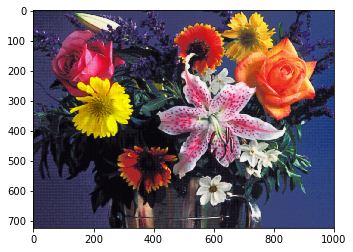

In [14]:
plt.imshow(out_img)
plt.show()

In [15]:
#计算PSNR
def calpsnr(self, im1, im2):
    diff = np.abs(im1 - im2)
    rmse = np.sqrt(np.mean(np.square(diff)))
    psnr = 20*np.log10(255/rmse)
    return psnr